In [1]:
import numpy as np
import pandas as pd
import datatable as dt
import time
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import seaborn as sns
from matplotlib import pyplot as plt
from plotly import graph_objs as go
plt.style.use('seaborn')

from sklearn import preprocessing
from sklearn import pipeline
from sklearn.pipeline import *
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import *
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

# Encoder
import category_encoders
from category_encoders.target_encoder import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder


# Home made
from cmougan import *

Read the data

In [2]:
accidents = pd.read_csv('Dataset & booklet/accidents.csv')
vehicles = pd.read_csv('Dataset & booklet/vehicles.csv')
test = pd.read_csv('Dataset & booklet/test.csv')

In [3]:
train = accidents

# Random Variable for baseline feature importance
train['rand'] = np.random.random(size=[train.shape[0],1])

Aggregated features from vehicles dataset

In [4]:
cat1 = pd.read_csv('Dataset & booklet/categorical_v1.csv')
cat2 = pd.read_csv('Dataset & booklet/categorical_v2.csv')
num1 = pd.read_csv('Dataset & booklet/numeric_v1.csv')
cat3 = pd.read_csv('Dataset & booklet/categorical_v3.csv')
cat4 = pd.read_csv('Dataset & booklet/categorical_v4.csv')

Merge of the aggregated variables to make a nice and good looking tabular dataset

In [5]:
train = pd.merge(train,num1,on='accident_id')
train = pd.merge(train,cat1,on='accident_id')
train = pd.merge(train,cat2,on='accident_id')


train = pd.merge(train,cat3,on='accident_id')
train = pd.merge(train,cat4,on='accident_id')


Erase some variables to release memory

In [6]:
del cat1,cat2,cat3,cat4,num1

A list of categorical variables that we are gonna encode later

In [7]:
cols_enc =['1st_road_class', '1st_road_number', 'road_type','speed_limit', 
           'junction_detail', 'junction_control', '2nd_road_class','pedestrian_crossing-human_control', 
           'pedestrian_crossing-physical_facilities', 'light_conditions', 'weather_conditions', 
           'road_surface_conditions', 'special_conditions_at_site', 'carriageway_hazards', 'urban_or_rural_area',
          'police_force', 'local_authority_district', 'local_authority_highway',
          'mode_Vehicle_Type', 'mode_Towing_and_Articulation', 'mode_Vehicle_Manoeuvre', 
           'mode_Vehicle_Location.Restricted_Lane', 'mode_Junction_Location', 'mode_Skidding_and_Overturning',
           'mode_Hit_Object_in_Carriageway', 'mode_Vehicle_Leaving_Carriageway', 'mode_Hit_Object_off_Carriageway',
           'mode_X1st_Point_of_Impact', 'mode_Was_Vehicle_Left_Hand_Drive.', 'mode_Journey_Purpose_of_Driver', 
           'mode_Sex_of_Driver', 'mode_Propulsion_Code','vehicles','impact_points','manoeuvres']

# Date

 Let's create some time feature and visualize them

In [8]:
df = train
df ['diaSemana'] = pd.to_datetime(train['date']).dt.day_name()
df['hour'] = df['time'].str[:2]
df['month'] = df.date.str[5:7]
df['night'] = (df['hour'].astype(int)>20) | (df['hour'].astype(int)<8)
df['weekend'] = (df['diaSemana']=='Saturday') | (df['diaSemana']=='Friday')
df['isPartytime'] = (df['weekend'] & df['night'])

Text(0, 0.5, 'No of Severe Accidents per hour')

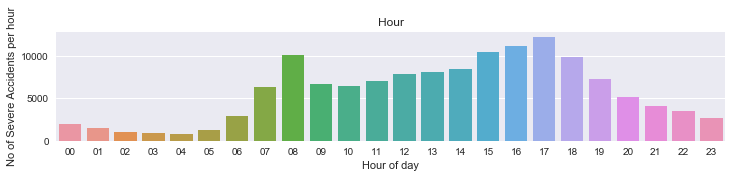

In [9]:
# pickup distribution, by weekday
plt.figure(figsize=(12,2))

data = df.groupby('hour').aggregate({'target':'count'}).reset_index()
sns.barplot(x='hour', y='target', data=data)

plt.title('Hour')
plt.xlabel('Hour of day')
#plt.xticks(range(0,7), dow_names, rotation='horizontal')
plt.ylabel('No of Severe Accidents per hour')


We can see that in rush hour we have more accident accumulation

Text(0, 0.5, 'No of Severe Accidents per hour')

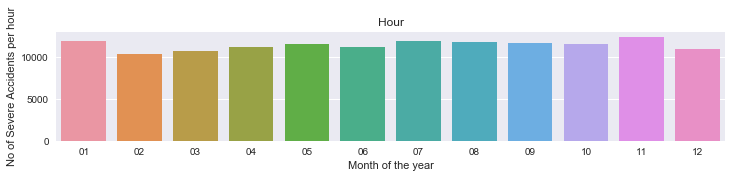

In [10]:
# pickup distribution, by weekday
plt.figure(figsize=(12,2))

data = df.groupby('month').aggregate({'target':'count'}).reset_index()
sns.barplot(x='month', y='target', data=data)

plt.title('Hour')
plt.xlabel('Month of the year')
#plt.xticks(range(0,7), dow_names, rotation='horizontal')
plt.ylabel('No of Severe Accidents per hour')


WE can see that the distribution of accidents is stationary during the year

### LSOA Feature
A Lower Layer Super Output Area (LSOA) is a GEOGRAPHIC AREA.

Lower Layer Super Output Areas are a geographic hierarchy designed to improve the reporting of small area statistics in England and Wales.

In [11]:
train['lsoa6'] = train['lsoa_of_accident_location'].str[:6]
train['lsoa7'] = train['lsoa_of_accident_location'].str[:7]
train['lsoa8'] = train['lsoa_of_accident_location'].str[:8]

Lets use this function that will allow us to reduce the memory in order to improve computational time

In [12]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 90.68 MB
Memory usage after optimization is: 20.92 MB
Decreased by 76.9%


Save the Data to use in the modeling part

In [13]:
#train.to_csv('Dataset & booklet/train_v1.csv', index=False)

# Adversarial Trainning

The main point of this section is to show which variables should be avoided when predicting severe accidents. 

If the variable predicts test/train split than there is shift in its distribution between test and train and that may lead to the error in predicting accident severity.



In [74]:
train = pd.read_csv('Dataset & booklet/accidents.csv')
test = pd.read_csv('Dataset & booklet/test.csv')

train['train'] = 1
test['train'] = 0
df = train.append(test)

df['year'] = df.date.str[:4].astype(int)


/Users/cmougan/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




Shuffle the data

In [75]:
from sklearn.utils import shuffle
df = shuffle(df)

In [76]:
# Split back
train = df[df['train']==1]
test = df[df['train']==0]
train = train.drop(columns='train')
test = test.drop(columns=['train','target'])



Split data to measure model performance

In [77]:
X_tr, X_te, y_tr, y_te = sklearn.model_selection.train_test_split(df.drop(columns=['train','target']),df.train,random_state=1)

Set of actions that build a mathematical modeling strategy.


In [78]:
cb = CatBoostClassifier(iterations=300)
te = Encodings()
pipe_cb = Pipeline([
    ('selector', TypeSelector(np.number)),   
    ('cb',cb)])

pipeline_grid = {
    "cb__depth": [None]
        }

In [79]:
# Execution Hyperparameters
n_jobs=1
cv = 3
n_max= 2_000
pipe_cv = GridSearchCV(pipe_cb, param_grid=pipeline_grid, n_jobs = n_jobs, cv=cv,scoring='roc_auc')


**Train Model**

In [80]:
pipe_cv, pipe_best_estimator  = fit_cv_subsample(pipe_cv, X_tr, y_tr, n_max = n_max);
pipe_best_estimator.fit(X_tr,y_tr);

Learning rate set to 0.05313
0:	learn: 0.5541843	total: 13.8ms	remaining: 4.13s
1:	learn: 0.4342719	total: 26.1ms	remaining: 3.9s
2:	learn: 0.3485523	total: 34.3ms	remaining: 3.39s
3:	learn: 0.2681498	total: 40.2ms	remaining: 2.98s
4:	learn: 0.2191216	total: 47.8ms	remaining: 2.82s
5:	learn: 0.1697849	total: 54.1ms	remaining: 2.65s
6:	learn: 0.1423502	total: 60.2ms	remaining: 2.52s
7:	learn: 0.1164183	total: 67.2ms	remaining: 2.45s
8:	learn: 0.0961556	total: 74ms	remaining: 2.39s
9:	learn: 0.0821564	total: 79.9ms	remaining: 2.32s
10:	learn: 0.0677827	total: 87.4ms	remaining: 2.3s
11:	learn: 0.0581085	total: 93.1ms	remaining: 2.23s
12:	learn: 0.0491598	total: 101ms	remaining: 2.22s
13:	learn: 0.0416828	total: 106ms	remaining: 2.16s
14:	learn: 0.0364364	total: 112ms	remaining: 2.13s
15:	learn: 0.0320765	total: 120ms	remaining: 2.13s
16:	learn: 0.0287035	total: 126ms	remaining: 2.1s
17:	learn: 0.0248257	total: 134ms	remaining: 2.09s
18:	learn: 0.0216602	total: 139ms	remaining: 2.06s
19:	l

182:	learn: 0.0004280	total: 1.18s	remaining: 756ms
183:	learn: 0.0004265	total: 1.19s	remaining: 750ms
184:	learn: 0.0004248	total: 1.19s	remaining: 743ms
185:	learn: 0.0004221	total: 1.2s	remaining: 739ms
186:	learn: 0.0004205	total: 1.21s	remaining: 733ms
187:	learn: 0.0004182	total: 1.22s	remaining: 726ms
188:	learn: 0.0004161	total: 1.22s	remaining: 718ms
189:	learn: 0.0004135	total: 1.23s	remaining: 712ms
190:	learn: 0.0004107	total: 1.24s	remaining: 706ms
191:	learn: 0.0004090	total: 1.24s	remaining: 698ms
192:	learn: 0.0004063	total: 1.25s	remaining: 692ms
193:	learn: 0.0004048	total: 1.25s	remaining: 685ms
194:	learn: 0.0004028	total: 1.26s	remaining: 677ms
195:	learn: 0.0004004	total: 1.26s	remaining: 671ms
196:	learn: 0.0003980	total: 1.27s	remaining: 664ms
197:	learn: 0.0003954	total: 1.27s	remaining: 656ms
198:	learn: 0.0003937	total: 1.28s	remaining: 650ms
199:	learn: 0.0003909	total: 1.28s	remaining: 643ms
200:	learn: 0.0003890	total: 1.29s	remaining: 636ms
201:	learn: 0

59:	learn: 0.0017853	total: 500ms	remaining: 2s
60:	learn: 0.0017420	total: 507ms	remaining: 1.99s
61:	learn: 0.0016452	total: 515ms	remaining: 1.98s
62:	learn: 0.0015859	total: 523ms	remaining: 1.97s
63:	learn: 0.0015452	total: 531ms	remaining: 1.96s
64:	learn: 0.0014806	total: 536ms	remaining: 1.94s
65:	learn: 0.0014450	total: 544ms	remaining: 1.93s
66:	learn: 0.0014108	total: 551ms	remaining: 1.91s
67:	learn: 0.0013928	total: 558ms	remaining: 1.9s
68:	learn: 0.0013347	total: 563ms	remaining: 1.88s
69:	learn: 0.0013184	total: 569ms	remaining: 1.87s
70:	learn: 0.0012793	total: 575ms	remaining: 1.85s
71:	learn: 0.0012456	total: 580ms	remaining: 1.84s
72:	learn: 0.0012277	total: 586ms	remaining: 1.82s
73:	learn: 0.0012017	total: 592ms	remaining: 1.81s
74:	learn: 0.0011887	total: 607ms	remaining: 1.82s
75:	learn: 0.0011663	total: 612ms	remaining: 1.8s
76:	learn: 0.0011369	total: 618ms	remaining: 1.79s
77:	learn: 0.0011241	total: 624ms	remaining: 1.77s
78:	learn: 0.0011125	total: 629ms	re

250:	learn: 0.0002370	total: 1.51s	remaining: 295ms
251:	learn: 0.0002362	total: 1.52s	remaining: 289ms
252:	learn: 0.0002354	total: 1.52s	remaining: 283ms
253:	learn: 0.0002345	total: 1.53s	remaining: 276ms
254:	learn: 0.0002340	total: 1.53s	remaining: 270ms
255:	learn: 0.0002329	total: 1.54s	remaining: 264ms
256:	learn: 0.0002321	total: 1.54s	remaining: 258ms
257:	learn: 0.0002311	total: 1.55s	remaining: 252ms
258:	learn: 0.0002304	total: 1.55s	remaining: 246ms
259:	learn: 0.0002293	total: 1.55s	remaining: 239ms
260:	learn: 0.0002287	total: 1.56s	remaining: 233ms
261:	learn: 0.0002280	total: 1.56s	remaining: 227ms
262:	learn: 0.0002268	total: 1.57s	remaining: 221ms
263:	learn: 0.0002258	total: 1.57s	remaining: 214ms
264:	learn: 0.0002248	total: 1.58s	remaining: 208ms
265:	learn: 0.0002239	total: 1.58s	remaining: 202ms
266:	learn: 0.0002230	total: 1.58s	remaining: 196ms
267:	learn: 0.0002223	total: 1.59s	remaining: 190ms
268:	learn: 0.0002212	total: 1.59s	remaining: 184ms
269:	learn: 

123:	learn: 0.0006436	total: 880ms	remaining: 1.25s
124:	learn: 0.0006388	total: 887ms	remaining: 1.24s
125:	learn: 0.0006321	total: 893ms	remaining: 1.23s
126:	learn: 0.0006221	total: 897ms	remaining: 1.22s
127:	learn: 0.0006150	total: 901ms	remaining: 1.21s
128:	learn: 0.0006113	total: 906ms	remaining: 1.2s
129:	learn: 0.0006065	total: 910ms	remaining: 1.19s
130:	learn: 0.0006033	total: 915ms	remaining: 1.18s
131:	learn: 0.0005979	total: 919ms	remaining: 1.17s
132:	learn: 0.0005912	total: 924ms	remaining: 1.16s
133:	learn: 0.0005881	total: 928ms	remaining: 1.15s
134:	learn: 0.0005827	total: 932ms	remaining: 1.14s
135:	learn: 0.0005780	total: 936ms	remaining: 1.13s
136:	learn: 0.0005742	total: 940ms	remaining: 1.12s
137:	learn: 0.0005701	total: 945ms	remaining: 1.11s
138:	learn: 0.0005660	total: 949ms	remaining: 1.1s
139:	learn: 0.0005637	total: 953ms	remaining: 1.09s
140:	learn: 0.0005572	total: 957ms	remaining: 1.08s
141:	learn: 0.0005509	total: 963ms	remaining: 1.07s
142:	learn: 0.

293:	learn: 0.0002615	total: 1.68s	remaining: 34.2ms
294:	learn: 0.0002606	total: 1.68s	remaining: 28.5ms
295:	learn: 0.0002599	total: 1.69s	remaining: 22.8ms
296:	learn: 0.0002592	total: 1.69s	remaining: 17.1ms
297:	learn: 0.0002584	total: 1.7s	remaining: 11.4ms
298:	learn: 0.0002571	total: 1.71s	remaining: 5.71ms
299:	learn: 0.0002566	total: 1.71s	remaining: 0us
Learning rate set to 0.059594
0:	learn: 0.5308410	total: 7.43ms	remaining: 2.22s
1:	learn: 0.4243455	total: 14.6ms	remaining: 2.18s
2:	learn: 0.3234565	total: 21.5ms	remaining: 2.13s
3:	learn: 0.2410355	total: 26.4ms	remaining: 1.95s
4:	learn: 0.1828339	total: 32.8ms	remaining: 1.94s
5:	learn: 0.1451208	total: 39.9ms	remaining: 1.95s
6:	learn: 0.1127321	total: 46.3ms	remaining: 1.94s
7:	learn: 0.0913863	total: 52.9ms	remaining: 1.93s
8:	learn: 0.0713771	total: 58.4ms	remaining: 1.89s
9:	learn: 0.0547673	total: 63.6ms	remaining: 1.84s
10:	learn: 0.0452195	total: 70.4ms	remaining: 1.85s
11:	learn: 0.0396329	total: 77.1ms	remain

189:	learn: 0.0002063	total: 1.12s	remaining: 647ms
190:	learn: 0.0002042	total: 1.13s	remaining: 643ms
191:	learn: 0.0002030	total: 1.13s	remaining: 637ms
192:	learn: 0.0002022	total: 1.14s	remaining: 631ms
193:	learn: 0.0002015	total: 1.14s	remaining: 625ms
194:	learn: 0.0002005	total: 1.15s	remaining: 618ms
195:	learn: 0.0001995	total: 1.15s	remaining: 612ms
196:	learn: 0.0001983	total: 1.16s	remaining: 605ms
197:	learn: 0.0001973	total: 1.16s	remaining: 598ms
198:	learn: 0.0001961	total: 1.17s	remaining: 592ms
199:	learn: 0.0001953	total: 1.17s	remaining: 585ms
200:	learn: 0.0001943	total: 1.18s	remaining: 579ms
201:	learn: 0.0001930	total: 1.18s	remaining: 572ms
202:	learn: 0.0001919	total: 1.18s	remaining: 566ms
203:	learn: 0.0001908	total: 1.19s	remaining: 560ms
204:	learn: 0.0001898	total: 1.19s	remaining: 553ms
205:	learn: 0.0001889	total: 1.2s	remaining: 547ms
206:	learn: 0.0001875	total: 1.2s	remaining: 540ms
207:	learn: 0.0001864	total: 1.21s	remaining: 534ms
208:	learn: 0.

49:	learn: 0.0000101	total: 2.85s	remaining: 14.3s
50:	learn: 0.0000100	total: 2.93s	remaining: 14.3s
51:	learn: 0.0000100	total: 2.99s	remaining: 14.3s
52:	learn: 0.0000099	total: 3.05s	remaining: 14.2s
53:	learn: 0.0000097	total: 3.11s	remaining: 14.2s
54:	learn: 0.0000097	total: 3.17s	remaining: 14.1s
55:	learn: 0.0000097	total: 3.24s	remaining: 14.1s
56:	learn: 0.0000097	total: 3.29s	remaining: 14s
57:	learn: 0.0000097	total: 3.35s	remaining: 14s
58:	learn: 0.0000097	total: 3.39s	remaining: 13.8s
59:	learn: 0.0000097	total: 3.44s	remaining: 13.8s
60:	learn: 0.0000097	total: 3.48s	remaining: 13.7s
61:	learn: 0.0000097	total: 3.54s	remaining: 13.6s
62:	learn: 0.0000097	total: 3.62s	remaining: 13.6s
63:	learn: 0.0000097	total: 3.69s	remaining: 13.6s
64:	learn: 0.0000097	total: 3.75s	remaining: 13.5s
65:	learn: 0.0000097	total: 3.8s	remaining: 13.5s
66:	learn: 0.0000097	total: 3.86s	remaining: 13.4s
67:	learn: 0.0000097	total: 3.93s	remaining: 13.4s
68:	learn: 0.0000097	total: 4.03s	re

210:	learn: 0.0000097	total: 16.6s	remaining: 7.01s
211:	learn: 0.0000097	total: 16.7s	remaining: 6.92s
212:	learn: 0.0000097	total: 16.7s	remaining: 6.83s
213:	learn: 0.0000097	total: 16.8s	remaining: 6.74s
214:	learn: 0.0000097	total: 16.8s	remaining: 6.66s
215:	learn: 0.0000097	total: 16.9s	remaining: 6.57s
216:	learn: 0.0000097	total: 17s	remaining: 6.49s
217:	learn: 0.0000097	total: 17s	remaining: 6.4s
218:	learn: 0.0000097	total: 17.1s	remaining: 6.31s
219:	learn: 0.0000097	total: 17.1s	remaining: 6.22s
220:	learn: 0.0000097	total: 17.2s	remaining: 6.13s
221:	learn: 0.0000097	total: 17.2s	remaining: 6.04s
222:	learn: 0.0000097	total: 17.2s	remaining: 5.95s
223:	learn: 0.0000097	total: 17.3s	remaining: 5.86s
224:	learn: 0.0000097	total: 17.3s	remaining: 5.78s
225:	learn: 0.0000097	total: 17.4s	remaining: 5.69s
226:	learn: 0.0000097	total: 17.4s	remaining: 5.61s
227:	learn: 0.0000097	total: 17.5s	remaining: 5.52s
228:	learn: 0.0000097	total: 17.5s	remaining: 5.43s
229:	learn: 0.000

In [81]:
print('The score of the gradient boosting algorithm in train is',
      np.round(auc_score(y_tr,pipe_best_estimator.predict_proba(X_tr)),decimals=2))

print('The score of the gradient boosting algorithm in test is',
      np.round(auc_score(y_te,pipe_best_estimator.predict_proba(X_te)),decimals=2))

The score of the gradient boosting algorithm in train is 1.0
The score of the gradient boosting algorithm in test is 1.0


7 features, reduction of 46.15%


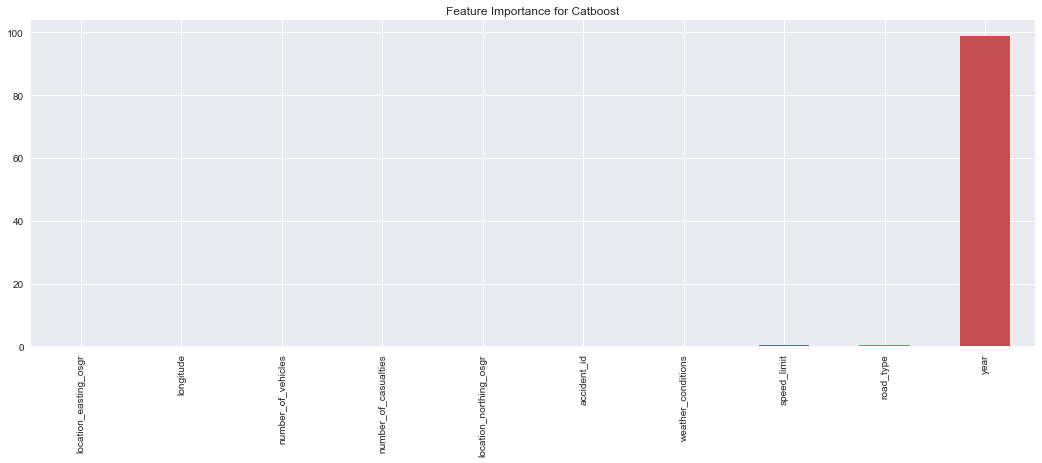

In [82]:
plot_feature_importance(pipe_best_estimator[:-1].transform(X_tr).columns,pipe_best_estimator.named_steps['cb'].get_feature_importance(),10)

We can achieve an AUC = 1 in Adversarial Trainning

**Insight** -> Train and test are splitted by time more over, in year

# Feature Differences between train and test

In [83]:
train = df[df['train']==1]
test = df[df['train']==0]
train = train.drop(columns='train')
test = test.drop(columns=['train','target'])

**Kolmogorov-Smirnov** statistic

(K–S test or KS test) is a nonparametric test of the equality of continuous one-dimensional probability distributions that can be used to compare a sample with a reference probability distribution (one-sample K–S test), or to compare two samples (two-sample K–S test).

The idea is to compute the Kolmogorov-Smirnov statistic on 2 samples to test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution.  This will allow us to see if there are major changes between a variable in the train and in the test dataset. 

The *KS* statistic test computes the KS statistic and pvalue. If the p value is less than .1 the null hypothesis is rejected. In this case you are sampling values from corresponding columns in test and train data frame and storing their pvalues in the list *Se*. If the p value is less than .1 the null hypothesis is rejected. Columns with pvalues less than 0.1 are added to the list_discarded.

In [84]:
df = df._get_numeric_data()
# Split back
train = df[df['train']==1]
test = df[df['train']==0]
train = train.drop(columns='train')
test = test.drop(columns=['train','target'])


In [85]:
# This tests whether 2 samples are drawn from the same distribution. The distribution is assumed to be continuous.
from scipy.stats import ks_2samp 
from tqdm import tqdm

list_p_value =[]

for i in tqdm(test.columns):
    list_p_value.append(ks_2samp(test[i] ,  train[i])[1])

Se = pd.Series(list_p_value, index = test.columns).sort_values() 
list_discarded = list(Se[Se < .4].index)

100%|██████████| 13/13 [00:00<00:00, 24.27it/s]


In [86]:
pd.DataFrame(Se).rename(columns={0:'p-value'})

,p-value
year,0.000000e+00
1st_road_number,5.347047e-119
speed_limit,8.349138e-36
longitude,8.503828e-35
location_northing_osgr,8.968612e-22
location_easting_osgr,1.764373e-19
weather_conditions,1.099368e-15
latitude,1.666175e-10
road_type,2.159817e-09
number_of_vehicles,3.082247e-07
